## DistilBertModel with data augmentation

##### Install libs needed

In [ ]:
!pip3 install torch 
!pip3 install torchvision
!pip3 install torchtext
!pip3 install pandas
!pip3 install nltk
!pip3 install -U scikit-learn scipy matplotlib
!pip3 install spacy
!pip3 install transformers datasets evaluate
!pip3 install --upgrade accelerate
!pip3 install textaugment
!pip3 install -U tqdm

##### Import libs 

In [ ]:
import pandas as pd
import numpy as np
import re
import torch
import torch.nn as nn
import matplotlib.pyplot as plt
import nltk
from nltk.corpus import stopwords
# Hugging Face Dataset
from datasets import Dataset
# Model performance evaluation
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification, TrainingArguments, Trainer, EarlyStoppingCallback, TextClassificationPipeline
import evaluate
import string
from tqdm import tqdm

In [ ]:
# This part is when you are using GPU of Nvidia.
device = torch.device("cpu")
# If we a GPU available, set the device to GPU. Only for Nvidia GPU
if torch.cuda.is_available:
  device = torch.device("cuda")
  print("GPU is available")
else:
  print("GPU is not available, CPU used")

GPU is available


In [ ]:
# Download the stopwords from nltk 
nltk.download('stopwords')
ntst = stopwords.words('english')
print(ntst)
print(len(ntst))

# Download the stopwords from spacy
from spacy.lang.en.stop_words import STOP_WORDS
print(STOP_WORDS)
print(len(STOP_WORDS))

# Merge the two stopwords above to one set
stwords = set(ntst).union(STOP_WORDS)
print(stwords)
print(len(stwords))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


{'thereby', "'s", 'mine', 'afterwards', 'everywhere', 'please', 'amongst', 'ours', 'whom', 'by', 'same', 'due', 'of', 'yourselves', 'as', 'serious', 'here', 'therefore', 'then', 'and', 'even', 'least', 'give', 'per', 'does', 'from', 'just', 'his', 'either', 'what', 'above', 'mostly', 'or', 'almost', 'something', 'whenever', 'using', 'only', 'other', 'nowhere', 'together', 'twelve', 'hundred', 'up', 'amount', 'seemed', 'say', 'became', 'hereafter', 'at', 'herself', '’d', 'thereupon', 'sometimes', 'have', 'somehow', '‘s', 'perhaps', 'always', 'any', 'nor', 'over', 'under', 'five', 'which', 'hereupon', 'with', 'thereafter', 'six', '‘m', 'in', 'former', 'both', 'first', 'for', '‘d', 'within', 'else', 'sometime', 'but', 'n‘t', '‘re', 'who', 'somewhere', 'anyone', 'never', '’ll', 'there', 'should', 'be', 'they', 'less', 'down', "'re", 'towards', 'front', 'had', 'while', 'eight', 'becomes', 'off', 'besides', 'anywhere', 'full', 'the', 'was', 'we', 'anyway', 'wherever', 'ca', 'behind', 'someon

In [ ]:
##### Preprocessing the data when reading the data from csv file #####

# Delete the stopwords
def delete_stopwords(text):
  text = str(text)
  tx_arr = text.split()
  [w for w in tx_arr if w not in stwords]
  return ' '.join( [w for w in tx_arr if w not in stwords])

# Clean string
def clean_str(string):
    string = str(string)
    string = re.sub(r"[^A-Za-z0-9(),!?\'\`]", " ", string)
    string = re.sub(r"\'s", " \'s", string)
    string = re.sub(r"\'ve", " \'ve", string)
    string = re.sub(r"n\'t", " n\'t", string)
    string = re.sub(r"\'re", " \'re", string)
    string = re.sub(r"\'d", " \'d", string)
    string = re.sub(r"\'ll", " \'ll", string)
    string = re.sub(r",", " , ", string)
    string = re.sub(r"!", " ! ", string)
    string = re.sub(r"\(", " \( ", string)
    string = re.sub(r"\)", " \) ", string)
    string = re.sub(r"\?", " \? ", string)
    string = re.sub(r"\s{2,}", " ", string)
    return string.strip().lower()

# Replace the empty text with np.NaN so that we can apply 'dropna' to the all the rows
def replace_empltytext(text):
  text = str(text)
  if text.isspace() or len(text) <= 0:
    text = np.NaN
  return text

# Load the csv file and do all the preprocessing mentioned above
def load_csv(file_path):
  df = pd.read_csv(file_path)
  df.columns = ["id","title","text","label"]
  df.drop(labels=['id','title'], axis='columns', inplace=True)
  df['text'] = df['text'].apply(clean_str)
  df['text'] = df['text'].apply(delete_stopwords)  
  df['text'] = df['text'].apply(replace_empltytext)
  df.dropna(inplace=True)
  return df

In [ ]:
# Upload the dataset to the google drive first, then run the following code to load the dataset
from google.colab import drive
drive.mount('/content/gdrive', force_remount=True)

Mounted at /content/gdrive


In [ ]:
# Make a finder named NLP and change the root path to this finder
import os
os.chdir("/content/gdrive/My Drive/NLP/")

In [ ]:
# Load data from Google drive
df = load_csv('./WELFake_Dataset.csv')

In [ ]:
# Training dataset
train_data = df.sample(frac=0.7, random_state=42)

test_data = df.drop(train_data.index)

# Validation dataset
val_data = test_data.sample(frac=(1.0 / 3), random_state=42)

# Testing dataset
test_data =  test_data.drop(val_data.index)

# Check the number of records in training and testing dataset.
print(f'The training dataset has {len(train_data)} records.')
print(f'The validation dataset has {len(val_data)} records.')
print(f'The testing dataset has {len(test_data)} records.')

The training dataset has 49972 records.
The validation dataset has 7139 records.
The testing dataset has 14277 records.


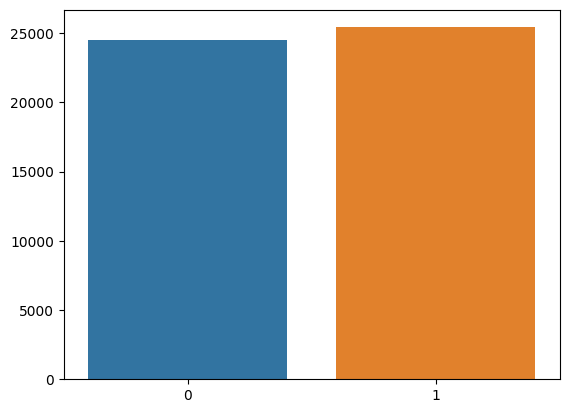

In [ ]:
import seaborn as sns
data_count = train_data['label'].value_counts()
sns.barplot(x=np.array([1,0]),y=data_count.values)
plt.show()

In [ ]:
nltk.download('punkt')
nltk.download('wordnet')
from textaugment import EDA
t = EDA()

# Create a new dataframe for augmented data
augmented_df = pd.DataFrame(columns=['text', 'label'])

# Apply augmentation
for index, row in tqdm(train_data.iterrows()):
  augmented_df.loc[len(augmented_df)] = {'text': t.synonym_replacement( row['text']), 'label': row['label']}

train_data = pd.concat([train_data, augmented_df]) 

[nltk_data] Downloading package punkt to /root/nltk_data...
[nltk_data]   Unzipping tokenizers/punkt.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...
49972it [02:59, 277.71it/s]


In [ ]:
augmented_df.info

<bound method DataFrame.info of                                                     text  label
0      white house flatly denying media reports trump...      0
1      geneva \( reuters \) venezuelan president nico...      0
2      realize , second amendment applies white peopl...      1
3      stocks marched higher higher 5 percent preside...      0
4      ! protesting flag know 13 stars unreal ! house...      1
...                                                  ...    ...
49967  \( reuters \) family australian woman fatally ...      0
49968  tel aviv \( reuters \) thousands israelis prot...      0
49969  seoul \( reuters \) united nations nuclear wat...      0
49970  difference , point , \? remember infamous wret...      1
49971  21st century wire says living rock 20 years , ...      1

[49972 rows x 2 columns]>

##### This code is for long sentence splitting, if needed, remove the

In [ ]:
# def split_long_doc(doc, seg_length):
#   res = []
#   ldoc = doc.split()
#   while len(ldoc) > seg_length:
#     res.append(' '.join(ldoc[:seg_length]))
#     ldoc = ldoc[seg_length:]
#   res.append(' '.join(ldoc))
#   return res

In [ ]:
# # Create a new dataframe for augmented data
# segmented_df = pd.DataFrame(columns=['text', 'label'])

# for index, row in tqdm(train_data.iterrows()):
#   segs = split_long_doc(row['text'], 395)
#   for s in segs:
#     segmented_df.loc[len(segmented_df)] = {'text': s, 'label': row['label']}

# segmented_df

In [ ]:
# If you only use the segmented dataset
# train_data = segmented_df 

# Merge original data with the segmented data
# tain_data = dp.concate([train_data, segmented_df])

In [ ]:
train_data.info

<bound method DataFrame.info of                                                     text  label
13840  white house flatly denying media reports trump...      0
53049  geneva \( reuters \) venezuelan president nico...      0
28777  realize , second amendment applies white peopl...      1
41932  stocks marched higher higher 5 percent preside...      0
54848  ! protesting flag know 13 stars unreal ! house...      1
...                                                  ...    ...
49967  \( reuters \) family australian woman fatally ...      0
49968  tel aviv \( reuters \) thousands israelis prot...      0
49969  seoul \( reuters \) united nations nuclear wat...      0
49970  difference , point , \? remember infamous wret...      1
49971  21st century wire says living rock 20 years , ...      1

[99944 rows x 2 columns]>

In [ ]:
# Convert pyhton dataframe to Hugging Face arrow dataset
hg_train_data = Dataset.from_pandas(train_data)
hg_val_data = Dataset.from_pandas(val_data)
hg_test_data = Dataset.from_pandas(test_data)

In [ ]:
# Tokenizer from a pretrained model
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased')
# Take a look at the tokenizer
tokenizer

DistilBertTokenizer(name_or_path='distilbert-base-uncased', vocab_size=30522, model_max_length=512, is_fast=False, padding_side='right', truncation_side='right', special_tokens={'unk_token': '[UNK]', 'sep_token': '[SEP]', 'pad_token': '[PAD]', 'cls_token': '[CLS]', 'mask_token': '[MASK]'}, clean_up_tokenization_spaces=True)

In [ ]:
# Mapping between special tokens and their IDs.
print(f'The unknown token is {tokenizer.unk_token} and the ID for the unkown token is {tokenizer.unk_token_id}.')
print(f'The seperator token is {tokenizer.sep_token} and the ID for the seperator token is {tokenizer.sep_token_id}.')
print(f'The pad token is {tokenizer.pad_token} and the ID for the pad token is {tokenizer.pad_token_id}.')
print(f'The sentence level classification token is {tokenizer.cls_token} and the ID for the classification token is {tokenizer.cls_token_id}.')
print(f'The mask token is {tokenizer.mask_token} and the ID for the mask token is {tokenizer.mask_token_id}.')


The unknown token is [UNK] and the ID for the unkown token is 100.
The seperator token is [SEP] and the ID for the seperator token is 102.
The pad token is [PAD] and the ID for the pad token is 0.
The sentence level classification token is [CLS] and the ID for the classification token is 101.
The mask token is [MASK] and the ID for the mask token is 103.


In [ ]:
# Funtion to tokenize data
def tokenize_dataset(data):
    return tokenizer(data['text'], max_length=400, truncation=True,padding="max_length")

# Tokenize the dataset
dataset_train = hg_train_data.map(tokenize_dataset)
dataset_test = hg_test_data.map(tokenize_dataset)
dataset_val = hg_val_data.map(tokenize_dataset)

Map:   0%|          | 0/99944 [00:00<?, ? examples/s]

Map:   0%|          | 0/14277 [00:00<?, ? examples/s]

Map:   0%|          | 0/7139 [00:00<?, ? examples/s]

In [ ]:
# Take a look at the data
print(dataset_train)
print(dataset_val)
print(dataset_test)

Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 99944
})
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 7139
})
Dataset({
    features: ['text', 'label', '__index_level_0__', 'input_ids', 'attention_mask'],
    num_rows: 14277
})


In [ ]:
# Load model
model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=2)
model.to(device)

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_transform.bias', 'vocab_layer_norm.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_projector.bias', 'vocab_transform.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['pre_classifier.bias', 'classifier.weight', 'classifier

DistilBertForSequenceClassification(
  (distilbert): DistilBertModel(
    (embeddings): Embeddings(
      (word_embeddings): Embedding(30522, 768, padding_idx=0)
      (position_embeddings): Embedding(512, 768)
      (LayerNorm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
      (dropout): Dropout(p=0.1, inplace=False)
    )
    (transformer): Transformer(
      (layer): ModuleList(
        (0-5): 6 x TransformerBlock(
          (attention): MultiHeadSelfAttention(
            (dropout): Dropout(p=0.1, inplace=False)
            (q_lin): Linear(in_features=768, out_features=768, bias=True)
            (k_lin): Linear(in_features=768, out_features=768, bias=True)
            (v_lin): Linear(in_features=768, out_features=768, bias=True)
            (out_lin): Linear(in_features=768, out_features=768, bias=True)
          )
          (sa_layer_norm): LayerNorm((768,), eps=1e-12, elementwise_affine=True)
          (ffn): FFN(
            (dropout): Dropout(p=0.1, inplace=False)
 

In [ ]:
# Set up training arguments
training_args = TrainingArguments(
    output_dir="./",          
    logging_dir='./logs',            
    logging_strategy='epoch',
    logging_steps=100,    
    num_train_epochs=10,              
    per_device_train_batch_size=32,  
    per_device_eval_batch_size=32,  
    learning_rate= 5e-6,
    seed=42,
    save_strategy='epoch',
    save_steps=100,
    evaluation_strategy='epoch',
    eval_steps=100,
    load_best_model_at_end=True
)

In [ ]:
# Number of evaluation modules
print(f'There are {len(evaluate.list_evaluation_modules())} evaluation models in Hugging Face.\n')

# List all evaluation metrics
evaluate.list_evaluation_modules()

In [ ]:
# define a function count the trainable parameters for a model
def count_trainable_parameters(model):
  total_params = sum(p.numel() for p in model.parameters() if p.requires_grad)
  print("Total Trainable Parameters:", total_params)

count_trainable_parameters(model)

Total Trainable Parameters: 66955010


In [ ]:
# Lock the parameters in bert, only train the pooler and classifier
for p in model.distilbert.parameters():
  p.requires_grad = False

# print(model.bert)
count_trainable_parameters(model)

Total Trainable Parameters: 592130


In [ ]:
# Function to compute the metric
def compute_metrics(eval_pred):
    metric = evaluate.load("accuracy")
    logits, labels = eval_pred
    predictions = np.argmax(logits, axis=1)
    return metric.compute(predictions=predictions, references=labels)

In [ ]:
# Before training, clear the temporary used RAM of system and GPU 
import torch, gc
gc.collect()
torch.cuda.empty_cache()

In [ ]:
# Define the trainer for the model
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

In [ ]:
# Start training
trainer.train()

In [ ]:
# Define the trainer for the model
trainer_test = Trainer(
    model=model,
    args=training_args,
    train_dataset=dataset_train,
    eval_dataset=dataset_val,
    compute_metrics=compute_metrics,
    callbacks=[EarlyStoppingCallback(early_stopping_patience=10)]
)

# Evaluate the model
trainer_test.evaluate()

{'eval_loss': 0.17617647349834442,
 'eval_accuracy': 0.9310827847037401,
 'eval_runtime': 93.6763,
 'eval_samples_per_second': 76.209,
 'eval_steps_per_second': 2.391}

In [ ]:
from sklearn.metrics import confusion_matrix
def calculate_tpr_fpr(y_real, y_pred):
    # Calculates the confusion matrix and recover each element
    cm = confusion_matrix(y_real, y_pred)
    TN = cm[0, 0]
    FP = cm[0, 1]
    FN = cm[1, 0]
    TP = cm[1, 1]
    # Calculates tpr and fpr
    tpr =  TP/(TP + FN) # sensitivity - true positive rate
    fpr = 1 - TN/(TN+FP) # 1-specificity - false positive rate
    return tpr, fpr

def get_n_roc_coordinates(y_real, y_proba, n = 50):
    tpr_list = [0]
    fpr_list = [0]
    for i in range(n):
        threshold = i/n
        y_pred = y_proba[:, 1] > threshold
        tpr, fpr = calculate_tpr_fpr(y_real, y_pred)
        tpr_list.append(tpr)
        fpr_list.append(fpr)
    return tpr_list, fpr_list


In [ ]:
def plot_roc_curve(tpr, fpr, scatter = True):
    plt.figure(figsize = (5, 5))
    if scatter:
        sns.scatterplot(x = fpr, y = tpr)
    sns.lineplot(x = fpr, y = tpr)
    sns.lineplot(x = [0, 1], y = [0, 1], color = 'green')
    plt.xlim(-0.05, 1.05)
    plt.ylim(-0.05, 1.05)
    plt.xlabel("False Positive Rate")
    plt.ylabel("True Positive Rate")

In [ ]:
# Calculates 10 coordinates of the ROC Curve
tpr, fpr = get_n_roc_coordinates(y_test, y_proba, resolution = 10)
# Plots the ROC curve
plot_roc_curve(tpr, fpr)

In [ ]:
# Save tokenizer
tokenizer.save_pretrained('./')

# Save model
trainer.save_model('./')